# Question 1 

# Fetching data from yfinance 

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
import os
from mpl_toolkits.mplot3d import Axes3D

# Define the stock symbol and download historical data
stock_symbol = "RR.L"
start_date = "2023-01-01"
end_date = "2023-07-01"

# Download historical data
df = yf.download(stock_symbol, start=start_date, end=end_date)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,94.760002,99.580002,94.599998,98.910004,98.910004,94742596
2023-01-04,97.800003,101.400002,95.750000,101.400002,101.400002,62168667
2023-01-05,101.779999,104.260002,101.360001,102.660004,102.660004,53910901
2023-01-06,103.239998,104.824997,102.760002,102.900002,102.900002,29053439
2023-01-09,103.000000,104.260002,100.919998,103.760002,103.760002,31156128


# calculation of normal return

In [2]:
import numpy as np
normal_return = []
for i in range(0,len(df)-1):
    adjclose_yesterday = df.iloc[i]['Adj Close']
    adjclose_today = df.iloc[i+1]['Adj Close']
    x = (adjclose_today - adjclose_yesterday) / adjclose_yesterday
    normal_return.append(x)
normal_return[:5]

[0.025174378440786613,
 0.012426056383331474,
 0.0023377932515904606,
 0.00835763457336078,
 -0.026407145689594385]

# Calculation of annualised normal return and annualised standard deviation

In [3]:
#Changing the list variable to numpy array:
normal_return=np.array(normal_return)
#calculating the mean and standard deviation using numpy:
mean_nr = normal_return.mean() * len(normal_return)
sd_nr = normal_return.std() * (len(normal_return) ** 0.5)
print(f"Annualized Average Return: {mean_nr:.4%}")
print(f"Annualized Standard Deviation: {sd_nr:.4%}")

Annualized Average Return: 47.8372%
Annualized Standard Deviation: 34.0007%


# Movement of equity price over time period

Text(0.5, 1.0, 'RR.L Stock Price Movement')

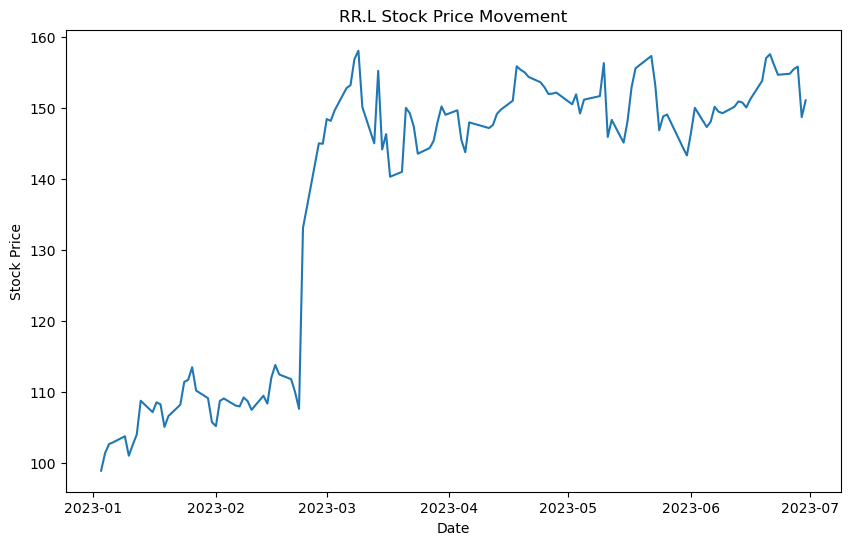

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
plt.plot(df['Close']) #choosing the series you want to plot
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('RR.L Stock Price Movement')

# Question 2 

# Data input for European put option

In [5]:
S0 = 98.91              # spot stock price
K = 149.45               # strike
T = 0.6                 # maturity 
r = 0.04                 # risk free rate 
sig = sd_nr               # standard deviation (volatility)
N = 3                   # number of periods or number of time steps  
payoff = "put"          # payoff 
sd_nr

0.34000739036963423

# Creating binomial tree

In [6]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1): #looping forwards, from 1 to N
    for i in range(z):  #looping forwards, from 0 to z-1
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1  # same as z=z+1

In [7]:
print('The binomial tree presenting Rolls Royce Holdings plc price over 3 time steps ', '\n\n', (S))

The binomial tree presenting Rolls Royce Holdings plc price over 3 time steps  

 [[ 98.91       115.15352906 134.06465731 156.08147216]
 [  0.          84.95777924  98.91       115.15352906]
 [  0.           0.          72.97365537  84.95777924]
 [  0.           0.           0.          62.68000913]]


In [8]:
print("The up factor u is",(u))

The up factor u is 1.1642253468753978


In [9]:
print("The down factor d is",(d))

The down factor d is 0.8589402409798469


In [10]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
print("The risk netural probablity is",(p))

The risk netural probablity is 0.48836920519613003


## Option value at each node

In [11]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
print('The option values at each node ', '\n\n', (V))

The option values at each node  

 [[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.         34.29647094]
 [ 0.          0.          0.         64.49222076]
 [ 0.          0.          0.         86.76999087]]


## Option value at earlier nodes 

In [12]:
# for European Option
for j in range(N-1, -1, -1): # Column. looping backwards. From N-1 to 0
    for i in range(j+1):  # Row. looping forwards. From 0 to j
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]) #the theoretical value at each node.
print('The option values at earlier nodes ', '\n\n', (V))

The option values at earlier nodes  

 [[47.75000411 33.48082995 17.40731365  0.        ]
 [ 0.         62.12004875 49.34916967 34.29647094]
 [ 0.          0.         75.2855143  64.49222076]
 [ 0.          0.          0.         86.76999087]]


In [13]:
print('European ' + payoff, str( V[0,0]))

European put 47.75000410864545


# Monte carlo simulation

In [14]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t])    
        # Price process, see Hilpisch (2015) chapter 1 (equation 1-1) & chapter 3 (equation 3-6)
    return S

## Data input 

In [15]:
T = 0.6
r = 0.04
sigma = sd_nr
S0 = 94.76
K = 149.45

In [16]:
S2 = mcs_simulation_np(1000)

## Graphical representation

fig = plt.figure()
plt.plot(S2)
fig.suptitle('Monte Carlo Simulation: Rolls Royce Holdings plc')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

In [17]:
S2 = np.transpose(S2)
S2

array([[ 94.76      ,  94.124477  ,  93.83643544, ..., 122.80532464,
        122.30345841, 122.77212791],
       [ 94.76      ,  94.91919247,  95.06299376, ..., 105.88063023,
        107.18334797, 107.7157746 ],
       [ 94.76      ,  95.09173878,  95.36866316, ..., 125.78980146,
        125.69097537, 125.11595257],
       ...,
       [ 94.76      ,  93.65667184,  92.97784606, ..., 145.88023907,
        146.44674147, 147.42388161],
       [ 94.76      ,  94.67241872,  93.98662425, ..., 107.26594212,
        107.96957466, 107.88370573],
       [ 94.76      ,  94.26122038,  94.7869436 , ...,  84.84080774,
         84.60859508,  83.46254806]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

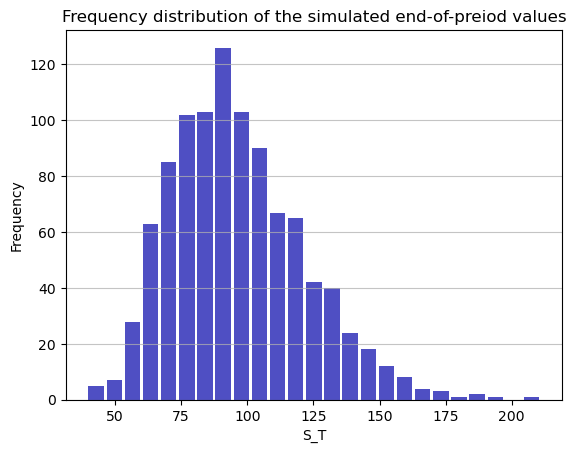

In [18]:
n, bins, patches = plt.hist(x=S2[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

## Option value

In [19]:
put = np.mean(np.maximum(K - S2[:,-1],0))
print('Monte Carlo Simulation & Option price - European put', str(put))

Monte Carlo Simulation & Option price - European put 53.342191255522366


# Delta

In [20]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [21]:
delta(S0, K, T, r, 0, sigma, 'put')

-0.9341124476385546

In [22]:
S11 = np.linspace(50,300,22)
Delta_Put = np.zeros((len(S11),1))
for i in range(len(S11)):
    Delta_Put [i] = delta(S11[i], K, T, r, 0, sigma, 'put')

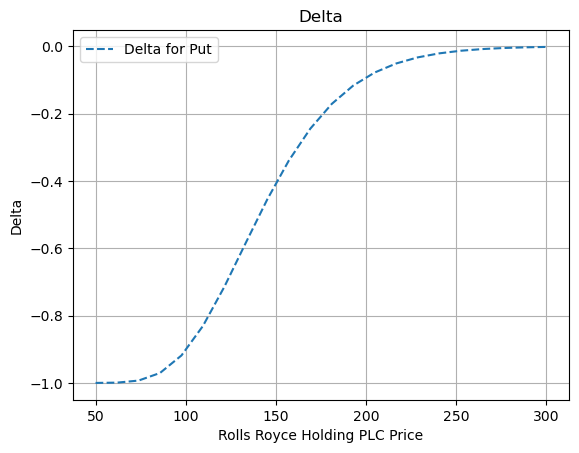

In [23]:
fig = plt.figure()

plt.plot(S11, Delta_Put, '--')
plt.grid()
plt.xlabel('Rolls Royce Holding PLC Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Put'])

In [24]:
S12 = np.linspace(50, 300, 22)
T12 = np.linspace(0.5, 2, 51)
Delta1 = np.zeros((len(T12),len(S12)))
for j in range(len(S12)):
    for i in range(len(T12)):
        Delta1[i,j] = delta(S12[j], K, T12[i], r, 0, sigma, 'put')

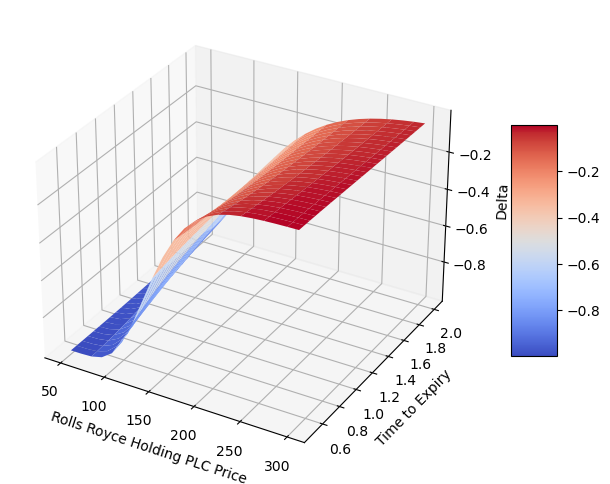

In [25]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
S12, T12 = np.meshgrid(S12, T12)
surf = ax.plot_surface(S12, T12, Delta1, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Rolls Royce Holding PLC Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Gamma

In [26]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [27]:
gamma(S0, K, T, r, 0, sigma, 'put')

0.005134264234165919

In [28]:
S21 = np.linspace(60,300,11)
Gamma1 = np.zeros((len(S21),1))
for i in range(len(S21)):
    Gamma1[i] = gamma(S21[i], K, T, r, 0, sigma, 'put')

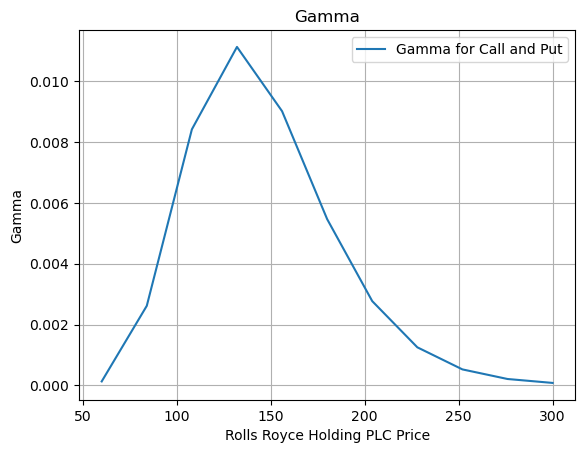

In [29]:
fig = plt.figure()
plt.plot(S21, Gamma1, '-')
plt.grid()
plt.xlabel('Rolls Royce Holding PLC Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

In [30]:
S22 = np.linspace(50, 300, 22)
T22 = np.linspace(0.5, 2, 51)
Gamma1 = np.zeros((len(T22),len(S22)))
for j in range(len(S22)):
    for i in range(len(T22)):
        Gamma1[i,j] = gamma(S22[j], K, T22[i], r, 0, sigma, 'put')

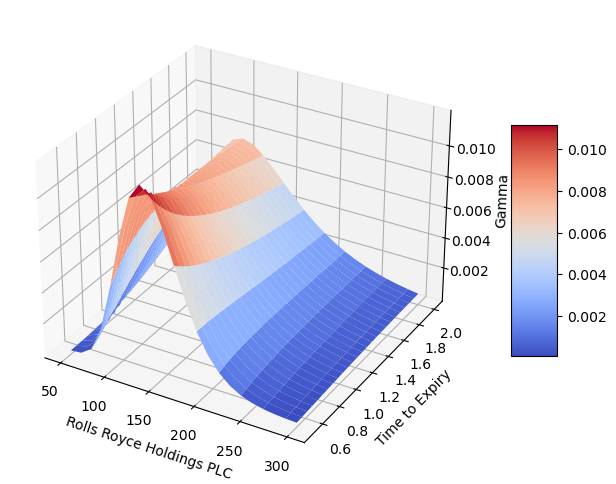

In [31]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
S22, T22 = np.meshgrid(S22, T22)
surf = ax.plot_surface(S22, T22, Gamma1, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Rolls Royce Holdings PLC')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Theta

In [32]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [33]:
theta(S0, K, T, r, 0, sigma, 'put')

8.277447552385576

In [34]:
T41 = np.linspace(60,300,11)
Theta_Call = np.zeros((len(T41),1))
Theta_Put = np.zeros((len(T41),1))
for i in range(len(T41)):
    Theta_Put [i] = theta(S0, K, T41[i], r, 0, sigma, 'put')

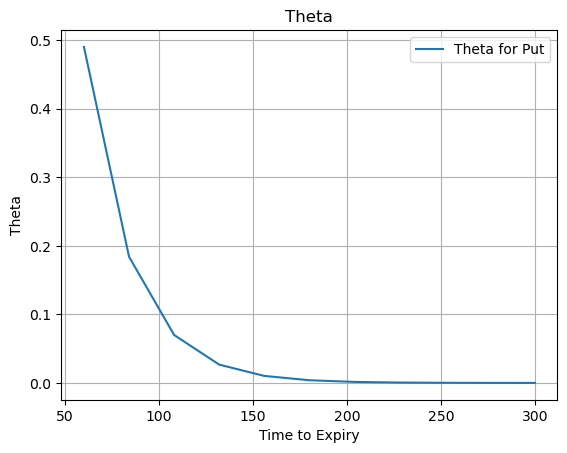

In [35]:
fig = plt.figure()
plt.plot(T41, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Put'])

In [36]:
S42 = np.linspace(60, 300, 22)
T42 = np.linspace(1/52, 3/52, 51)
Theta1 = np.zeros((len(T42),len(S42)))
for j in range(len(S42)):
    for i in range(len(T42)):
        Theta1[i,j] = theta(S42[j], K, T42[i], r, 0, sigma, 'put')

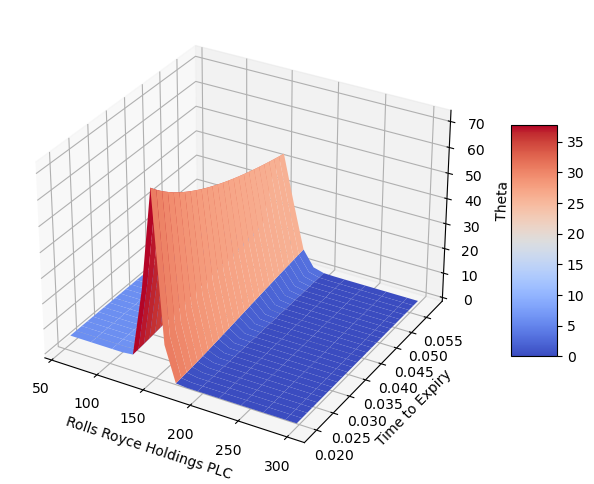

In [37]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
S42, T42 = np.meshgrid(S42, T42)
surf = ax.plot_surface(S42, T42, Theta1, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Rolls Royce Holdings PLC')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# RHO

In [38]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [39]:
rho(S0, K, T, r, 0, sigma, 'put')

-84.18875437331863

In [40]:
r1 = np.linspace(0.01,0.1,11)
Rho_Call = np.zeros((len(r1),1))
Rho_Put = np.zeros((len(r1),1))
for i in range(len(r1)):
    Rho_Put [i] = rho(S0, K, T, r1[i], 0, sigma, 'put')

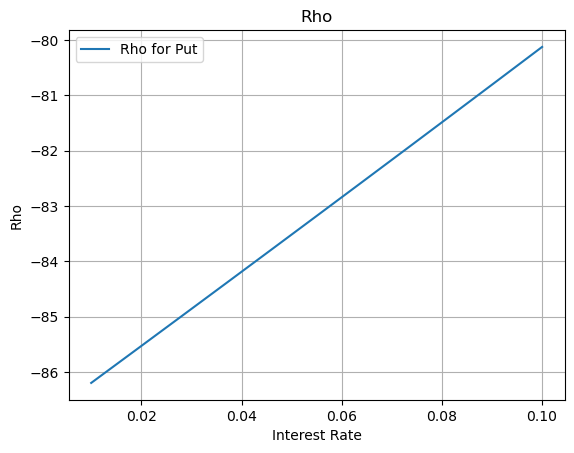

In [41]:
fig = plt.figure()
plt.plot(r1, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend([ 'Rho for Put'])

In [42]:
S53 = np.linspace(60, 300, 51)
T53 = np.linspace(0.5, 2, 51)
Rho3 = np.zeros((len(T53),len(S53)))
for j in range(len(S53)):
    for i in range(len(T53)):
        Rho3[i,j] = rho(S53[j], K, T53[i], r, 0, sigma, 'put')

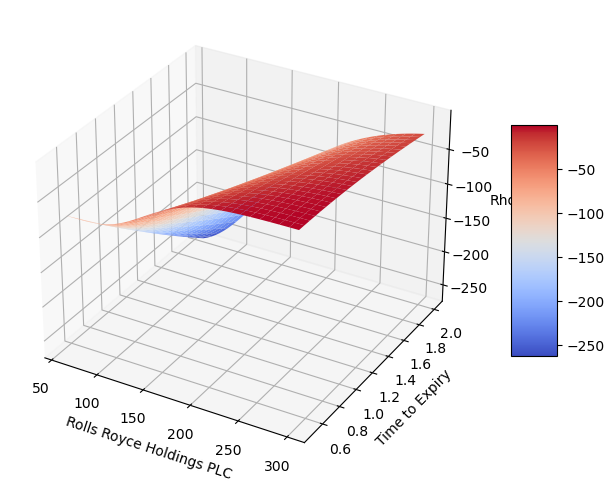

In [43]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
S53, T53 = np.meshgrid(S53, T53)
surf = ax.plot_surface(S53, T53, Rho3, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Rolls Royce Holdings PLC')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Vega

In [44]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [45]:
vega(S0, K, T, r, 0, sigma, 'put')

9.40519766208822

In [46]:
volvega = np.linspace(0.1,0.4,13)
Vega = np.zeros((len(volvega),1))
for i in range(len(volvega)):
    Vega [i] = vega(S0, K, T, r, 0, volvega[i], 'put')

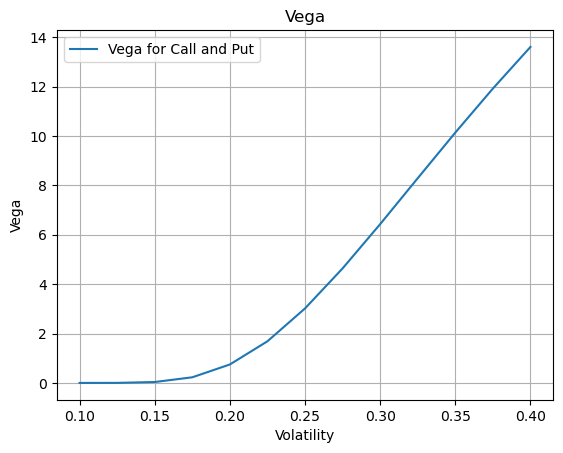

In [47]:
fig = plt.figure()
plt.plot(volvega, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call and Put'])

In [48]:
S63 = np.linspace(50, 300, 51)
T63 = np.linspace(0.5, 2, 51)
Vega2 = np.zeros((len(T63),len(S63)))
for j in range(len(S63)):
    for i in range(len(T63)):
        Vega2[i,j] = vega(S63[j], K, T63[i] , r, 0, sigma, 'put')

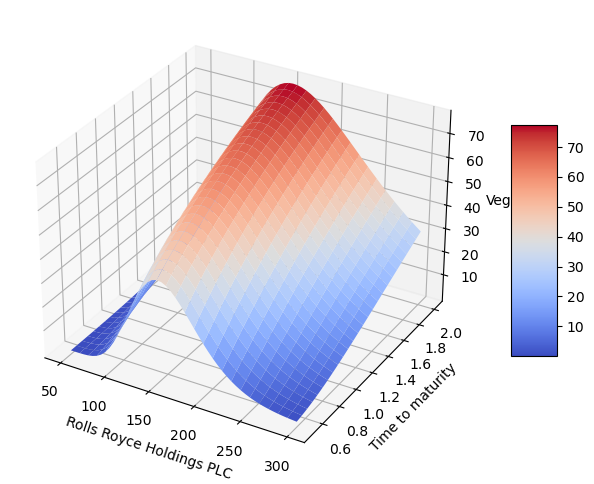

In [49]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
S63, T63 = np.meshgrid(S63,T63)
surf = ax.plot_surface(S63, T63, Vega2, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Rolls Royce Holdings PLC')
ax.set_ylabel('Time to maturity')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);